In [1]:
import os

import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh

import netket as nk
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import LocalOperator, GraphOperator, spin

import matplotlib.pyplot as plt

Selected two-point correlation pairs: [(0, 3)]


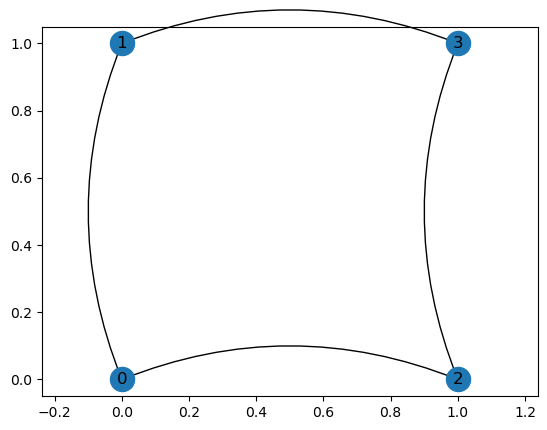

In [2]:
# set system parameters
SIDE_LENGTH = 2
PERIODIC_BOUNDARIES = False
MARSHALL_SIGN = True


def main_diagonal_pairs(graph, pbc):
    coords = np.asarray(graph.basis_coords, dtype=int)
    xy_to_id = {(c[0], c[1]): i for i, c in enumerate(coords)}

    # pick out the main diagonal nodes from our 2D grid
    diag_nodes = [xy_to_id[(k, k)] for k in range(coords[:, 0].max() + 1)]
    pairs = list(zip(diag_nodes, diag_nodes[1:]))

    # wrap-around in case of PBC
    if pbc:
        pairs.append((diag_nodes[-1], diag_nodes[0]))

    return pairs


#### DRAW GRAPH AND SELECT CORRELATION PAIRS ####

graph = Hypercube(length=SIDE_LENGTH, n_dim=2, pbc=PERIODIC_BOUNDARIES)
graph.draw()

# we wanna print out the selected pairs since after data generation we don't have access to the graph anymore
corr_pairs = main_diagonal_pairs(graph, PERIODIC_BOUNDARIES)
print(f"Selected two-point correlation pairs: {corr_pairs}")

In [3]:
# For odd N, we get degenerate ground states with magnetization +0.5 and -0.5.
# Our ED solver (eigsh) may return any linear combination of these states producing complex amplitudes.
# We cannot eliminate degeneracy by restricting total_sz because the Cxx operator changes total magnetization.
hilbert = Spin(s=0.5, N=graph.n_nodes)


def xxz_hamiltonian(hilbert, graph, delta, marshall_sign_rule=True, epsilon=1e-3):

    sx = nk.operator.spin.sigmax
    sy = nk.operator.spin.sigmay
    sz = nk.operator.spin.sigmaz

    # create a local 2-site Hilbert space as 4x4 matrix
    bond_hilbert = Spin(s=0.5, N=2)
    xy_bond_op = sx(bond_hilbert, 0)*sx(bond_hilbert, 1) + sy(bond_hilbert, 0)*sy(bond_hilbert, 1)
    zz_bond_op = sz(bond_hilbert, 0)*sz(bond_hilbert, 1)

    # white and black sublattices are defined by the even or odd number of hops from a starting site
    # flipping XY coupling forces bloch sphere to rotate 180 degrees around Z at black checkerboard sites
    xy_coeff = -delta if marshall_sign_rule else delta
    bond_op = xy_coeff * xy_bond_op + zz_bond_op
    bond_matrix = bond_op.to_dense()

    # broadcast 2-site bond operator to full Hilbert space
    H_xxz = GraphOperator(hilbert, graph=graph, bond_ops=[bond_matrix])

    # to lift degeneracy for odd N systems we add a tiny field
    # this operator contributes only to the main diagonal and does not change matrix sparsity
    H_field = LocalOperator(hilbert, dtype=np.complex128)
    for i in range(graph.n_nodes):
        H_field -= epsilon * sz(hilbert, i)

    return H_xxz + H_field


def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    # the 'smallest algebraic' argument tells us to look for the lowest eigenvalue
    # k=1 tells to stop after the first eigenvalue/eigenvector has converged
    vals, vecs = eigsh(sp_mat, k=1, which="SA")

    psi = vecs[:, 0]

    # eigsh may produce an arbitrary global phase. We take the element with the largest magnitude
    # and rotate the entire wavefunction so that this element is real and positive.
    first_idx = np.argmax(np.abs(psi))
    phase = np.angle(psi[first_idx])
    psi = psi * np.exp(-1j * phase)

    return vals[0], psi


#### CHECKING WHETHER THE WF IS REAL AND POSITIVE ####

print(f"{'='*60}")
print(f"HAMILTONIAN ANALYSIS (Delta=1.0, Marshall={MARSHALL_SIGN})")
print(f"Degeneracy broken via tiny field eps=1e-3)")
print(f"{'='*60}")

ham = xxz_hamiltonian(hilbert, graph, delta=1.0, marshall_sign_rule=MARSHALL_SIGN)
E0, psi = get_ground_state(ham)

print(f"Ground State Energy: {E0:.8f}")

nonzero_indices = np.where(np.abs(psi) > 1e-5)[0]
print(f"\nFirst 5 Non-Zero Amplitudes:")
print(f"{'Index':<6} | {'Real Part':<11} | {'Imag Part':<11} | {'Sign'}")
print("-" * 45)
for i in nonzero_indices[:5]:
    val = psi[i]
    sign = "+" if val.real > 0 else "-"
    print(f"{i:<6} | {val.real:+.6f}   | {val.imag:+.6f}   | {sign}")


sp_mat = ham.to_sparse()
off_diag = sp_mat - scipy.sparse.diags(sp_mat.diagonal())
max_off_diag = np.max(off_diag.data.real) if off_diag.nnz > 0 else 0.0

max_imag = np.max(np.abs(psi.imag))
min_real = np.min(psi.real)

is_stoquastic = max_off_diag <= 1e-12
is_real_positive = (max_imag < 1e-10) and (min_real > -1e-10)

print(f"\n{'='*60}")
print(f"PROPERTY SUMMARY")
print(f"{'='*60}")
print(f"1. Hamiltonian Stoquastic?   {str(is_stoquastic).upper():<5} (Max Off-Diag: {max_off_diag:.1e})")
print(f"2. Wavefunction Real?        {str(max_imag < 1e-10).upper():<5} (Max Imag:     {max_imag:.1e})")
print(f"3. Wavefunction Positive?    {str(min_real > -1e-10).upper():<5} (Min Real:     {min_real:.1e})\n")

if is_real_positive and MARSHALL_SIGN:
    print("SUCCESS: The state is Real and Positive. It is valid for our amplitude RBM.")
elif not is_real_positive and MARSHALL_SIGN:
    print("FAILURE: Marshall rule is ON, but state has negative/complex amplitudes.")
elif not MARSHALL_SIGN:
    print("SUCCESS: Physical state generated (Alternating signs expected).")

HAMILTONIAN ANALYSIS (Delta=1.0, Marshall=True)
Degeneracy broken via tiny field eps=1e-3)
Ground State Energy: -8.00000000

First 5 Non-Zero Amplitudes:
Index  | Real Part   | Imag Part   | Sign
---------------------------------------------
3      | +0.288675   | +0.000000   | +
5      | +0.288675   | -0.000000   | +
6      | +0.577350   | -0.000000   | +
9      | +0.577350   | +0.000000   | +
10     | +0.288675   | +0.000000   | +

PROPERTY SUMMARY
1. Hamiltonian Stoquastic?   TRUE  (Max Off-Diag: -2.0e+00)
2. Wavefunction Real?        TRUE  (Max Imag:     2.2e-16)
3. Wavefunction Positive?    TRUE  (Min Real:     -1.8e-16)

SUCCESS: The state is Real and Positive. It is valid for our amplitude RBM.


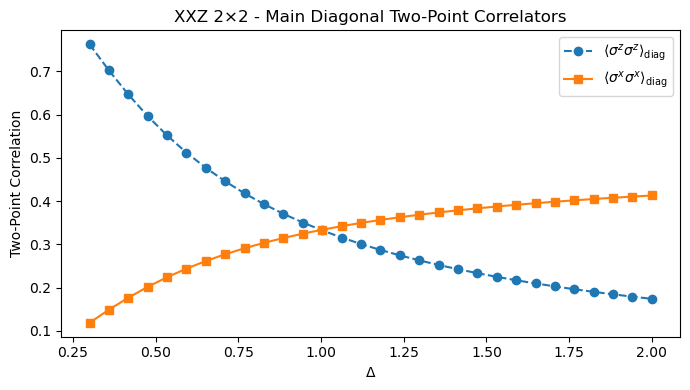

In [4]:
# we don't wanna map back to the physical frame here. We simply take the correlators for the given state at face value.

# we build the two-point correlators using NetKet as reference
def two_point_correlators(state: np.ndarray, pair_indices):
    psi = np.asarray(state, dtype=np.complex128)
    n = len(pair_indices)

    Czz = LocalOperator(hilbert, dtype=np.complex128)
    Cxx = LocalOperator(hilbert, dtype=np.complex128)

    for u, v in pair_indices:
        Czz += spin.sigmaz(hilbert, u) * spin.sigmaz(hilbert, v)
        Cxx += spin.sigmax(hilbert, u) * spin.sigmax(hilbert, v)

    Czz_sp = Czz.to_sparse()
    Cxx_sp = Cxx.to_sparse()

    czz = np.vdot(psi, Czz_sp @ psi).real / n
    cxx = np.vdot(psi, Cxx_sp @ psi).real / n

    return czz, cxx


#### SWEEP OVER DELTA ####

delta_min = 0.3
delta_max = 2.0
num_points = 30
deltas = np.linspace(delta_min, delta_max, num_points)

czz_vals, cxx_vals = [], []
for delta in deltas:
    ham = xxz_hamiltonian(hilbert, graph, float(delta), marshall_sign_rule=MARSHALL_SIGN)
    _, psi = get_ground_state(ham)
    czz, cxx = two_point_correlators(psi, corr_pairs)
    czz_vals.append(czz)
    cxx_vals.append(cxx)

cxx_vals = np.array(cxx_vals)
czz_vals = np.array(czz_vals)


#### PLOTTING ####

plt.figure(figsize=(7, 4))
plt.plot(deltas, czz_vals, "o--", label=r"$\langle \sigma^z \sigma^z \rangle_{\rm diag}$")
plt.plot(deltas, cxx_vals, "s-",  label=r"$\langle \sigma^x \sigma^x \rangle_{\rm diag}$")

plt.xlabel(r"$\Delta$")
plt.ylabel("Two-Point Correlation")
plt.title(f"XXZ {SIDE_LENGTH}×{SIDE_LENGTH} - Main Diagonal Two-Point Correlators")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
data = np.column_stack([deltas, czz_vals, cxx_vals])
header = "delta,czz_diag,cxx_diag"

file_name = f"xxz_{SIDE_LENGTH}x{SIDE_LENGTH}_correlations_ref.csv"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Saved reference correlators to: {os.path.abspath(file_name)}")

Saved reference correlators to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_square_2x2/xxz_2x2_correlations_ref.csv
